In [2]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
import json
import os


In [7]:
class AnimalsDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        with open(annotations_file, 'r') as f:
            self.coco = json.load(f)
        self.img_dir = img_dir
        self.transforms = transforms
        self.images = self.coco['images']
        self.annotations = self.coco['annotations']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = read_image(img_path).float() / 255.0  # Normalizar a [0,1]
        
        # Obtener anotaciones
        annots = [a for a in self.annotations if a['image_id'] == img_info['id']]
        boxes = [annot['bbox'] for annot in annots]
        labels = [annot['category_id'] for annot in annots]
        
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "class_labels": torch.tensor(labels, dtype=torch.int64),  # Nueva clave
        }
        
        if self.transforms:
            image, target = self.transforms(image, target)
        
        return image, target



In [8]:
from transformers import YolosForObjectDetection, YolosImageProcessor

# Cargar modelo y procesador preentrenado
model = YolosForObjectDetection.from_pretrained("hustvl/yolos-tiny")
processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

# Ajustar el número de clases (añade 1 para la categoría 'background')
model.num_labels = len(["cat", "chicken", "cow", "dog", "fox", "goat", "horse", "person", "racoon", "skunk"]) + 1
model.id2label = {i: label for i, label in enumerate(["background", "cat", "chicken", "cow", "dog", "fox", "goat", "horse", "person", "racoon", "skunk"])}
model.label2id = {label: i for i, label in model.id2label.items()}


In [12]:
import torch
from torch.optim import AdamW
from torch.nn.functional import cross_entropy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Configurar optimizador
optimizer = AdamW(model.parameters(), lr=1e-4)

# Inicializa el procesador
# processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

def train_one_epoch(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for images, targets in dataloader:
        # Procesar imágenes con el procesador de YOLOS
        pixel_values = processor(images=[img.permute(1, 2, 0).numpy() for img in images], return_tensors="pt").pixel_values
        
        # Mover los datos al dispositivo
        pixel_values = pixel_values.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Adelante y retropropagación
        outputs = model(pixel_values=pixel_values, labels=targets)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
    return total_loss / len(dataloader)


In [13]:
from torch.utils.data import DataLoader

train_dataset = AnimalsDataset('./animals/train/annotations.json', './animals/train')
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [14]:
# Variables para el checkpoint y parada anticipada
best_loss = float('inf')  # Inicializa con un valor muy alto
initial_loss = None
stop_training = False

# Directorio para guardar los checkpoints
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
# Bucle de entrenamiento con checkpoints y parada anticipada

epochs = 150
for epoch in range(epochs):
    if stop_training:
        print("Entrenamiento detenido debido a un aumento significativo en la pérdida.")
        break

    loss = train_one_epoch(model, train_loader, optimizer)

    # Establecer la pérdida inicial (solo en la primera época)
    if initial_loss is None:
        initial_loss = loss

    # Guardar el modelo si mejora la pérdida
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"best_model_epoch_{epoch+1}.pth"))
        print(f"Checkpoint guardado en la época {epoch+1} con pérdida {best_loss:.4f}")

    # Detener el entrenamiento si la pérdida aumenta un 10% del valor inicial
    if loss > 1.1 * initial_loss:
        print(f"Entrenamiento detenido en la época {epoch+1}. Pérdida: {loss:.4f}, inicial: {initial_loss:.4f}")
        stop_training = True
    else:
        print(f"Época {epoch+1}, Pérdida: {loss:.4f}")


Checkpoint guardado en la época 1 con pérdida 3492.9107
Época 1, Pérdida: 3492.9107
Checkpoint guardado en la época 2 con pérdida 3488.7885
Época 2, Pérdida: 3488.7885
Checkpoint guardado en la época 3 con pérdida 3484.8753
Época 3, Pérdida: 3484.8753
Época 4, Pérdida: 3484.9192
Época 5, Pérdida: 3488.5550
Checkpoint guardado en la época 6 con pérdida 3479.9639
Época 6, Pérdida: 3479.9639
Época 7, Pérdida: 3493.4800
Época 8, Pérdida: 3483.4660
Época 9, Pérdida: 3483.7899
Checkpoint guardado en la época 10 con pérdida 3478.0631
Época 10, Pérdida: 3478.0631
Época 11, Pérdida: 3488.7811
Checkpoint guardado en la época 12 con pérdida 3475.9570
Época 12, Pérdida: 3475.9570
Época 13, Pérdida: 3490.4862
Época 14, Pérdida: 3490.7564
Época 15, Pérdida: 3497.6937
Época 16, Pérdida: 3491.9922
Época 17, Pérdida: 3492.1481
Época 18, Pérdida: 3483.0092
Época 19, Pérdida: 3481.9588
Época 20, Pérdida: 3477.8242
Época 21, Pérdida: 3488.3708
Época 22, Pérdida: 3482.8602
Época 23, Pérdida: 3486.6638
Époc

In [6]:
for images, targets in train_loader:
    for img, tgt in zip(images, targets):
        print("Image shape:", img.shape)  # Debería ser (3, altura, ancho)
        print("Boxes shape:", tgt['boxes'].shape)  # (n_boxes, 4)
        print("Labels shape:", tgt['labels'].shape)  # (n_boxes,)


Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([6, 4])
Labels shape: torch.Size([6])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.

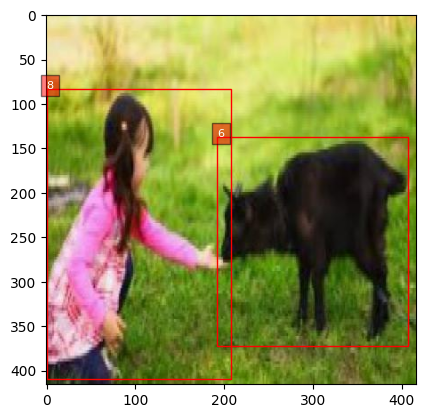

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_sample(dataset, idx):
    image, target = dataset[idx]
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0).numpy())
    for box, label in zip(target["boxes"], target["labels"]):
        rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], str(label.item()), color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

visualize_sample(train_dataset, 0)
